In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d 'puneet6060/intel-image-classification'

 99% 343M/346M [00:10<00:00, 37.6MB/s]
100% 346M/346M [00:10<00:00, 34.2MB/s]


In [6]:
import zipfile
dataset_zip = zipfile.ZipFile('intel-image-classification.zip','r')
dataset_zip.extractall()
dataset_zip.close()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [8]:
train_dataset_path = '/content/seg_train/seg_train'


Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [9]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32
validation_split = 0.2

In [10]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest',
                                  validation_split = validation_split)

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   subset='training')

validation_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                         target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [11]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


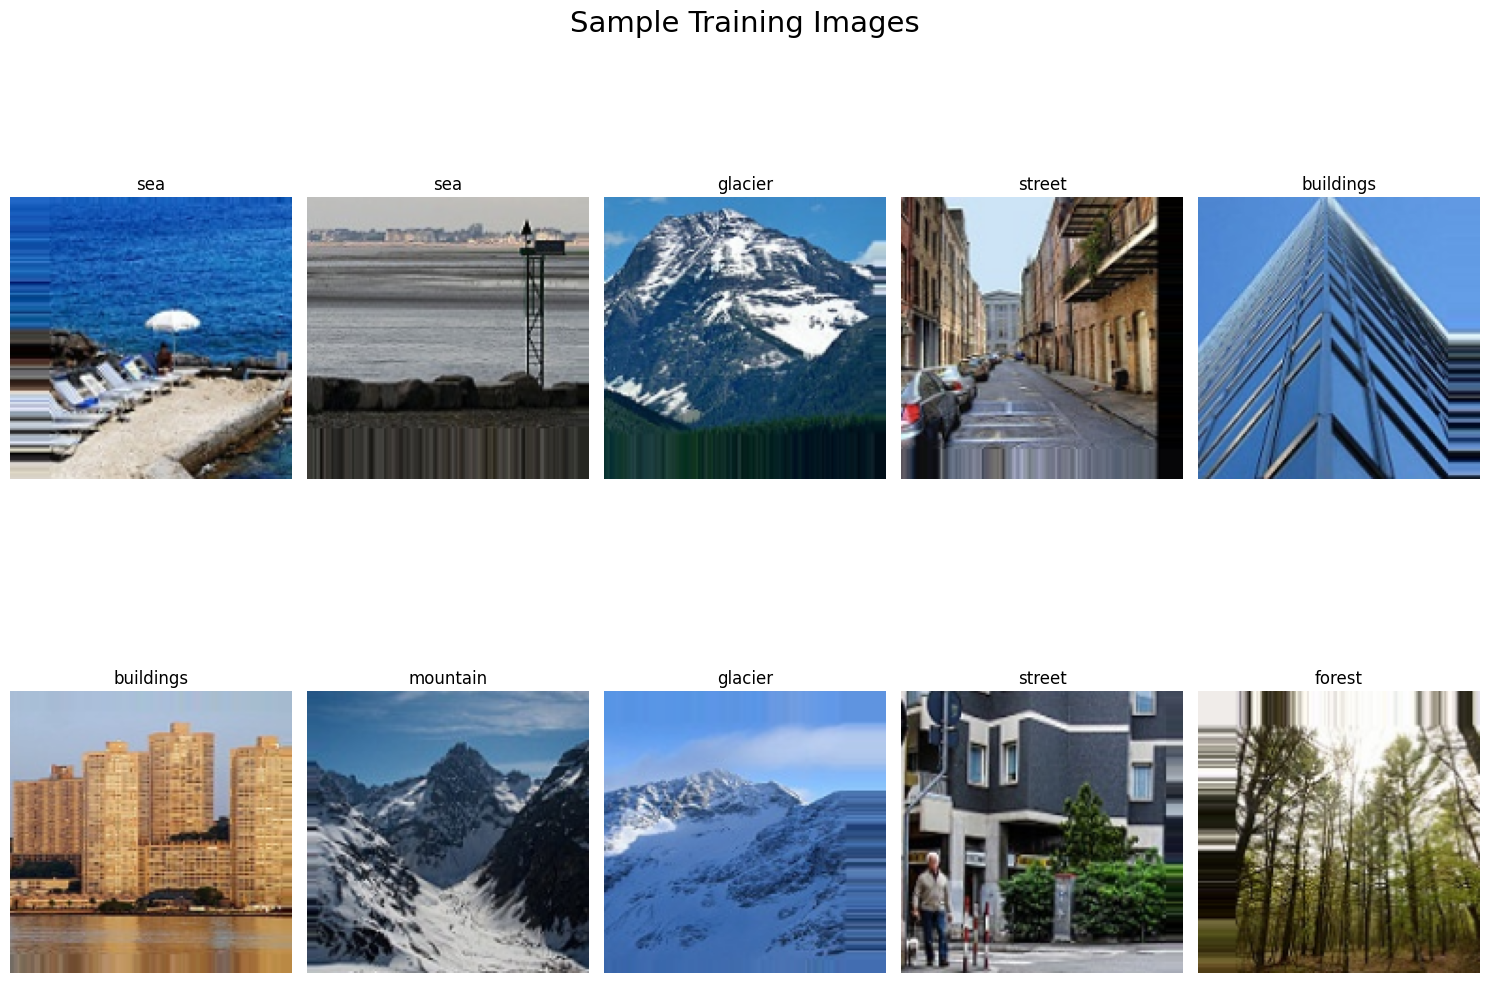

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [13]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])

    return model

In [14]:
cnn_model = create_model()

In [15]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [17]:
optimizer = Adam(learning_rate=0.001)

In [18]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.82 and logs.get('val_accuracy') > 0.82:
            self.model.stop_training = True

checkpoint_callback = myCallback()
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr,checkpoint_callback])

Epoch 1/50
351/351 - 95s - loss: 0.8968 - accuracy: 0.6736 - val_loss: 1.1365 - val_accuracy: 0.5792 - lr: 0.0010 - 95s/epoch - 271ms/step
Epoch 2/50
351/351 - 94s - loss: 0.8395 - accuracy: 0.6933 - val_loss: 1.1221 - val_accuracy: 0.6295 - lr: 0.0010 - 94s/epoch - 269ms/step
Epoch 3/50
351/351 - 93s - loss: 0.7962 - accuracy: 0.7115 - val_loss: 1.0321 - val_accuracy: 0.6419 - lr: 0.0010 - 93s/epoch - 264ms/step
Epoch 4/50
351/351 - 96s - loss: 0.7700 - accuracy: 0.7284 - val_loss: 0.6891 - val_accuracy: 0.7571 - lr: 0.0010 - 96s/epoch - 274ms/step
Epoch 5/50
351/351 - 93s - loss: 0.7238 - accuracy: 0.7402 - val_loss: 1.2292 - val_accuracy: 0.5703 - lr: 0.0010 - 93s/epoch - 264ms/step
Epoch 6/50
351/351 - 92s - loss: 0.6987 - accuracy: 0.7560 - val_loss: 0.9260 - val_accuracy: 0.6708 - lr: 0.0010 - 92s/epoch - 262ms/step
Epoch 7/50
351/351 - 94s - loss: 0.6710 - accuracy: 0.7663 - val_loss: 0.7419 - val_accuracy: 0.7147 - lr: 0.0010 - 94s/epoch - 268ms/step
Epoch 8/50
351/351 - 93s - 

In [21]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

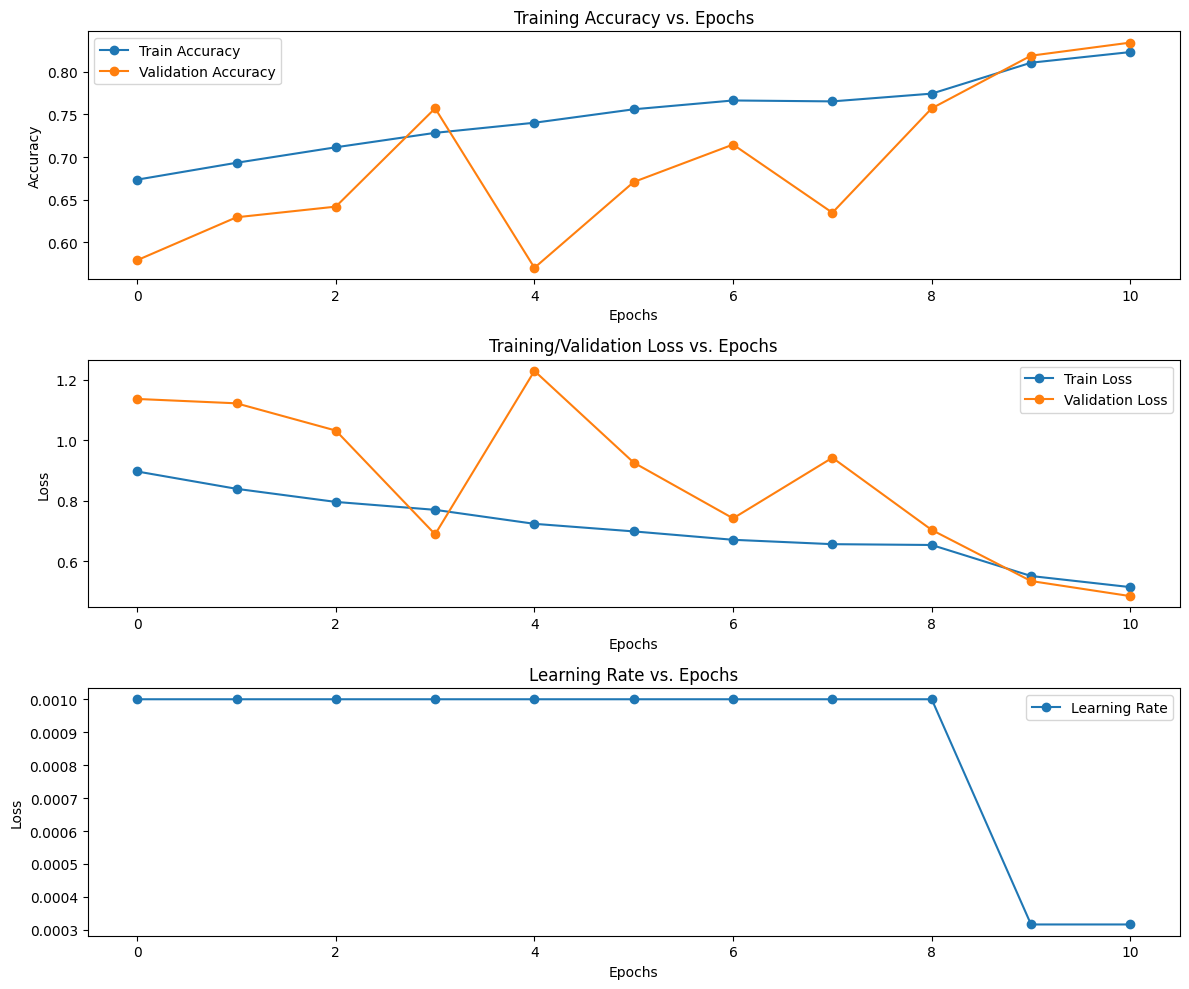

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [26]:
test_dataset = '/content/seg_test/seg_test'

In [27]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [28]:
predictions = cnn_model.predict(test_generator)

94/94 [==============================] - 4s 38ms/step


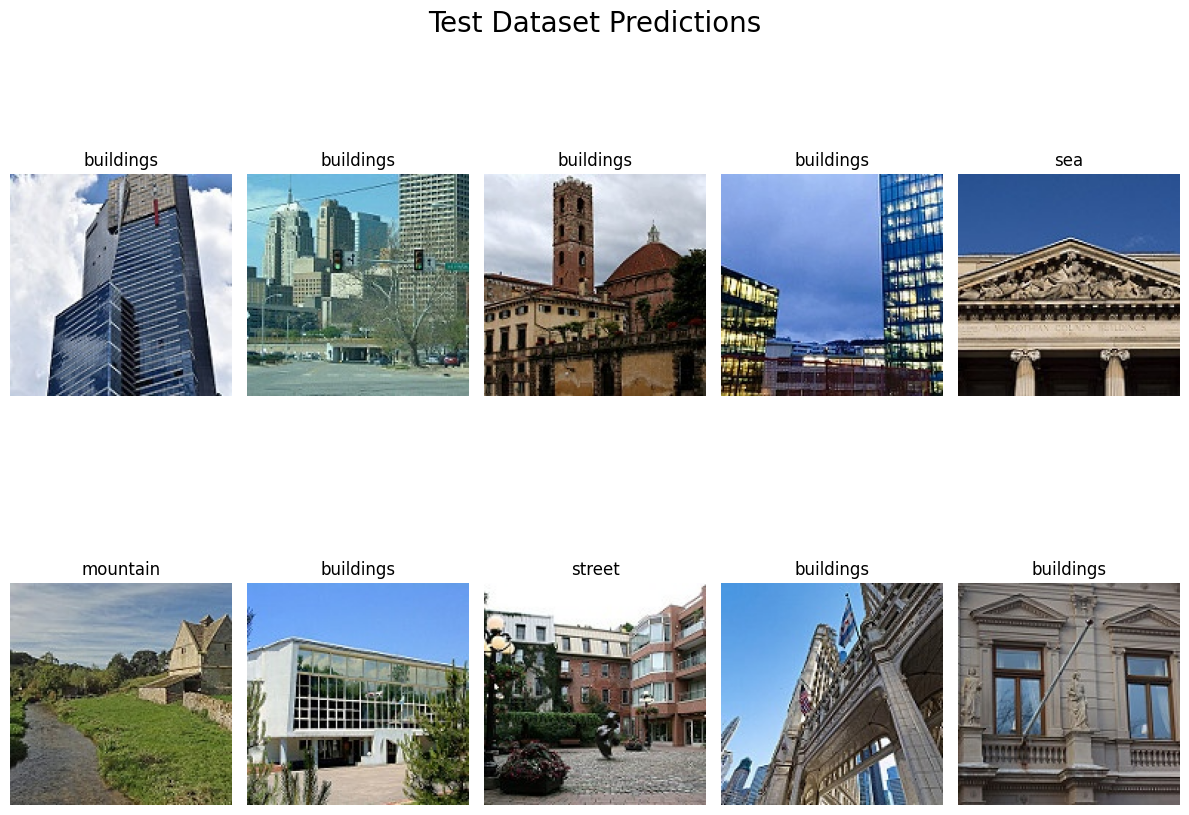

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [30]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 3s 33ms/step - loss: 0.4137 - accuracy: 0.8550


In [31]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.41371792554855347
Test Accuracy: 0.8550000190734863


In [33]:
import tensorflow as tf
model = create_model()
# Assuming 'model' is your trained TensorFlow model
# model = ...

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
